<a href="https://colab.research.google.com/github/verachamochumbi/News_Classification-lab/blob/main/News_Classification0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1. Setteando el espacio:**

In [1]:
%cd /content
!git clone https://github.com/verachamochumbi/News_Classification-lab.git
%cd News_Classification-lab
!ls


/content
Cloning into 'News_Classification-lab'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 7 (delta 0), reused 4 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (7/7), 10.41 KiB | 5.20 MiB/s, done.
/content/News_Classification-lab
data  README.md


In [3]:
import os

dirs = [
    "src",
    "data",
    "notebooks",
    "outputs"
]

for d in dirs:
    os.makedirs(d, exist_ok=True)

print("Estructura creada:")
!ls -R


Estructura creada:
.:
data  notebooks  outputs  README.md  src

./data:
rss_feed.json

./notebooks:

./outputs:

./src:


In [5]:
!pip install -q "torch==2.8.0" "torchvision==0.23.0" "torchaudio==2.8.0" \
  "transformers==4.44.2" "datasets==2.21.0" "evaluate==0.4.2" \
  "scikit-learn==1.6.0" "matplotlib==3.9.2" "seaborn==0.13.2"


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.9/887.9 MB 809.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 106.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 132.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 57.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 706.8/706.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 83.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.5/267.5 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.2/288.2 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [1]:
import torch; print(torch.__version__)


2.8.0+cu128


**2. Crear el archivo src/train_eval.py**

In [3]:
%cd /content/News_Classification-lab


/content/News_Classification-lab


In [4]:
!mkdir -p src data outputs notebooks


In [27]:
%%writefile src/train_eval.py
import os
import json
import numpy as np
import evaluate
from datasets import load_dataset
from sklearn.metrics import f1_score
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
)

def train_one(model_name='FacebookAI/roberta-base',
              epochs=1,
              batch_size=8,
              max_length=96,
              train_samples=None,   # ahora sí están definidos
              val_samples=None,
              test_samples=None):
    # 1️⃣ Cargar y dividir AG News: 70/15/15
    ds = load_dataset("ag_news")
    tv = ds["train"].train_test_split(test_size=0.30, seed=42)   # 70/30
    vt = tv["test"].train_test_split(test_size=0.50, seed=42)    # 15/15
    data = {"train": tv["train"], "validation": vt["train"], "test": vt["test"]}

    # 2️⃣ Submuestreo opcional
    if train_samples:
        data["train"] = data["train"].shuffle(seed=42).select(range(min(train_samples, len(data["train"]))))
    if val_samples:
        data["validation"] = data["validation"].shuffle(seed=42).select(range(min(val_samples, len(data["validation"]))))
    if test_samples:
        data["test"] = data["test"].shuffle(seed=42).select(range(min(test_samples, len(data["test"]))))


    # 3️⃣ Tokenizador y modelo
    tok = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=4)

    def tok_fn(batch):
        return tok(batch["text"], truncation=True, padding="max_length", max_length=max_length)

    tokenized = {k: v.map(tok_fn, batched=True) for k, v in data.items()}
    tokenized = {k: tokenized[k].rename_column("label", "labels").with_format("torch") for k in tokenized}

    # 4️⃣ Métricas con scikit-learn
    def compute_metrics(p):
        preds = np.argmax(p.predictions, axis=1)
        acc = accuracy_score(p.label_ids, preds)
        f1m = f1_score(p.label_ids, preds, average="macro")
        return {"accuracy": acc, "f1_macro": f1m}

    # 5️⃣ Configuración de entrenamiento
    out_dir = f"outputs/{model_name.split('/')[-1]}"
    os.makedirs(out_dir, exist_ok=True)

    try:
        args = TrainingArguments(
            output_dir=out_dir,
            learning_rate=2e-5,
            per_device_train_batch_size=batch_size,
            per_device_eval_batch_size=batch_size,
            num_train_epochs=epochs,
            weight_decay=0.01,
            evaluation_strategy="epoch",
            save_strategy="epoch",
            report_to="none",
            load_best_model_at_end=True,
            metric_for_best_model="f1_macro",
            fp16=True  # activa precisión mixta (rápido en GPU)
        )
    except TypeError:
        args = TrainingArguments(
            output_dir=out_dir,
            learning_rate=2e-5,
            per_device_train_batch_size=batch_size,
            per_device_eval_batch_size=batch_size,
            num_train_epochs=epochs,
            weight_decay=0.01,
            report_to="none",
        )

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=tokenized["train"],
        eval_dataset=tokenized["validation"],
        compute_metrics=compute_metrics,
    )

    trainer.train()
    eval_res = trainer.evaluate(tokenized["test"])

    with open(os.path.join(out_dir, "metrics.json"), "w") as f:
        json.dump(eval_res, f, indent=2)

    return {
        "model": model_name,
        "accuracy": float(eval_res.get("eval_accuracy", 0.0)),
        "f1_macro": float(eval_res.get("eval_f1_macro", 0.0)),
    }

Overwriting src/train_eval.py


In [29]:
%cd /content/News_Classification-lab
import sys, inspect

# Fuerza a que /content/News_Classification-lab esté primero en el path
if sys.path[0] != "/content/News_Classification-lab":
    sys.path.insert(0, "/content/News_Classification-lab")

# Intenta importar y muestra de dónde viene
import src.train_eval as te
print("IMPORTADO DESDE:", te.__file__)              # <- debe apuntar a /content/News_Classification-lab/src/train_eval.py
print("FIRMA:", inspect.signature(te.train_one))    # <- debe mostrar train_samples, val_samples, test_samples


/content/News_Classification-lab
IMPORTADO DESDE: /content/News_Classification-lab/src/train_eval.py
FIRMA: (model_name='FacebookAI/roberta-base', epochs=1, batch_size=8, max_length=96)


In [30]:
%cd /content/News_Classification-lab
import sys, os
if sys.path[0] != os.getcwd():
    sys.path.insert(0, os.getcwd())
print("cwd:", os.getcwd())
print("sys.path[0]:", sys.path[0])


/content/News_Classification-lab
cwd: /content/News_Classification-lab
sys.path[0]: /content/News_Classification-lab


In [31]:
code = """
import os, json, numpy as np
from datasets import load_dataset
from sklearn.metrics import f1_score, accuracy_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer

def train_one_small(model_name='FacebookAI/roberta-base',
                    epochs=1,
                    batch_size=8,
                    max_length=96,
                    train_samples=None,
                    val_samples=None,
                    test_samples=None):
    # 1) Cargar y dividir AG News: 70/15/15
    ds = load_dataset('ag_news')
    tv = ds['train'].train_test_split(test_size=0.30, seed=42)   # 70/30
    vt = tv['test'].train_test_split(test_size=0.50, seed=42)    # 15/15
    data = {'train': tv['train'], 'validation': vt['train'], 'test': vt['test']}

    # 2) Submuestreo opcional
    if train_samples:
        data['train'] = data['train'].shuffle(seed=42).select(range(min(train_samples, len(data['train']))))
    if val_samples:
        data['validation'] = data['validation'].shuffle(seed=42).select(range(min(val_samples, len(data['validation']))))
    if test_samples:
        data['test'] = data['test'].shuffle(seed=42).select(range(min(test_samples, len(data['test']))))

    # 3) Tokenizador y modelo
    tok = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=4)

    def tok_fn(batch):
        return tok(batch['text'], truncation=True, padding='max_length', max_length=max_length)

    tokenized = {k: v.map(tok_fn, batched=True) for k, v in data.items()}
    tokenized = {k: tokenized[k].rename_column('label', 'labels').with_format('torch') for k in tokenized}

    # 4) Métricas con scikit-learn
    def compute_metrics(p):
        preds = np.argmax(p.predictions, axis=1)
        acc = accuracy_score(p.label_ids, preds)
        f1m = f1_score(p.label_ids, preds, average='macro')
        return {'accuracy': acc, 'f1_macro': f1m}

    # 5) Configuración de entrenamiento
    out_dir = f"outputs/{model_name.split('/')[-1]}"
    os.makedirs(out_dir, exist_ok=True)

    try:
        args = TrainingArguments(
            output_dir=out_dir,
            learning_rate=2e-5,
            per_device_train_batch_size=batch_size,
            per_device_eval_batch_size=batch_size,
            num_train_epochs=epochs,
            weight_decay=0.01,
            evaluation_strategy='epoch',
            save_strategy='epoch',
            report_to='none',
            load_best_model_at_end=True,
            metric_for_best_model='f1_macro',
            fp16=True
        )
    except TypeError:
        # Fallback si tu transformers no soporta flags modernos
        args = TrainingArguments(
            output_dir=out_dir,
            learning_rate=2e-5,
            per_device_train_batch_size=batch_size,
            per_device_eval_batch_size=batch_size,
            num_train_epochs=epochs,
            weight_decay=0.01,
            report_to='none',
        )

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=tokenized['train'],
        eval_dataset=tokenized['validation'],
        compute_metrics=compute_metrics,
    )

    trainer.train()
    eval_res = trainer.evaluate(tokenized['test'])

    with open(os.path.join(out_dir, 'metrics.json'), 'w') as f:
        json.dump(eval_res, f, indent=2)

    return {
        'model': model_name,
        'accuracy': float(eval_res.get('eval_accuracy', 0.0)),
        'f1_macro': float(eval_res.get('eval_f1_macro', 0.0)),
    }
"""
with open("src/train_small.py", "w") as f:
    f.write(code)

# Confirma que se escribió
!sed -n '1,80p' src/train_small.py



import os, json, numpy as np
from datasets import load_dataset
from sklearn.metrics import f1_score, accuracy_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer

def train_one_small(model_name='FacebookAI/roberta-base',
                    epochs=1,
                    batch_size=8,
                    max_length=96,
                    train_samples=None,
                    val_samples=None,
                    test_samples=None):
    # 1) Cargar y dividir AG News: 70/15/15
    ds = load_dataset('ag_news')
    tv = ds['train'].train_test_split(test_size=0.30, seed=42)   # 70/30
    vt = tv['test'].train_test_split(test_size=0.50, seed=42)    # 15/15
    data = {'train': tv['train'], 'validation': vt['train'], 'test': vt['test']}

    # 2) Submuestreo opcional
    if train_samples:
        data['train'] = data['train'].shuffle(seed=42).select(range(min(train_samples, len(data['train']))))
    if val_samples:
        data['vali

**3. Corremos roberta**

In [32]:
import importlib.util, pathlib, gc, sys, shutil

# Limpia posibles cachés de 'src'
shutil.rmtree("src/__pycache__", ignore_errors=True)
for k in list(sys.modules.keys()):
    if k.startswith("src.") or k == "src":
        del sys.modules[k]

module_path = pathlib.Path("/content/News_Classification-lab/src/train_small.py")
spec = importlib.util.spec_from_file_location("train_small_runtime", module_path)
train_small_runtime = importlib.util.module_from_spec(spec)
spec.loader.exec_module(train_small_runtime)

# Verifica firma (DEBE mostrar train_samples, val_samples, test_samples)
import inspect
print("FIRMA:", inspect.signature(train_small_runtime.train_one_small))

# Entrena rápido con subset
res = train_small_runtime.train_one_small(
    model_name='FacebookAI/roberta-base',
    epochs=1,
    batch_size=8,
    max_length=64,
    train_samples=1000,
    val_samples=500,
    test_samples=500
)
res


FIRMA: (model_name='FacebookAI/roberta-base', epochs=1, batch_size=8, max_length=96, train_samples=None, val_samples=None, test_samples=None)


/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,No log,0.409607,0.862000,0.861717


{'model': 'FacebookAI/roberta-base',
 'accuracy': 0.898,
 'f1_macro': 0.8962708341197079}

*Ahora que el modelito de roberta funciona con pocas muestras, arrancamos con el deberta y modernbert para luego comparar*

**4. corremos Deberta**

In [33]:
res_deberta = train_small_runtime.train_one_small(
    model_name="microsoft/deberta-v3-small",
    epochs=1,
    batch_size=8,
    max_length=64,
    train_samples=1000,
    val_samples=500,
    test_samples=500
)
res_deberta


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/578 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:551: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/286M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,No log,0.713472,0.754000,0.739229


{'model': 'microsoft/deberta-v3-small',
 'accuracy': 0.766,
 'f1_macro': 0.7393688754862481}

**5. Corremos ModernBert**

In [35]:

candidates = [
    "answerdotai/modernbert-small",
    "answerdotai/ModernBERT-small",
    "bertin-project/modernbert-small",
]

modern_res = None
for m in candidates:
    try:
        modern_res = train_small_runtime.train_one_small(
            model_name=m,
            epochs=1,
            batch_size=8,     # si hay OOM baja a 4
            max_length=64,
            train_samples=1000,
            val_samples=500,
            test_samples=500
        )
        print("OK con:", m); break
    except Exception as e:
        print("Falló", m, "->", type(e).__name__, e)

# fallback ultra-seguro si todos fallan (no es ModernBERT, pero te deja completar la comparación)
if modern_res is None:
    modern_res = train_small_runtime.train_one_small(
        model_name="distilroberta-base",
        epochs=1, batch_size=8, max_length=64,
        train_samples=1000, val_samples=500, test_samples=500
    )
    print("Usando fallback: distilroberta-base")

modern_res



Falló answerdotai/modernbert-small -> OSError answerdotai/modernbert-small is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `huggingface-cli login` or by passing `token=<your_token>`
Falló answerdotai/ModernBERT-small -> OSError answerdotai/ModernBERT-small is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `huggingface-cli login` or by passing `token=<your_token>`
Falló bertin-project/modernbert-small -> OSError bertin-project/modernbert-small is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `hu

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/331M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,No log,0.400965,0.864000,0.864066


Usando fallback: distilroberta-base


{'model': 'distilroberta-base',
 'accuracy': 0.886,
 'f1_macro': 0.8832029224889382}

**6. Comparamos resultados**

                        model  f1_macro
0     FacebookAI/roberta-base  0.896271
1  microsoft/deberta-v3-small  0.739369
2          distilroberta-base  0.883203


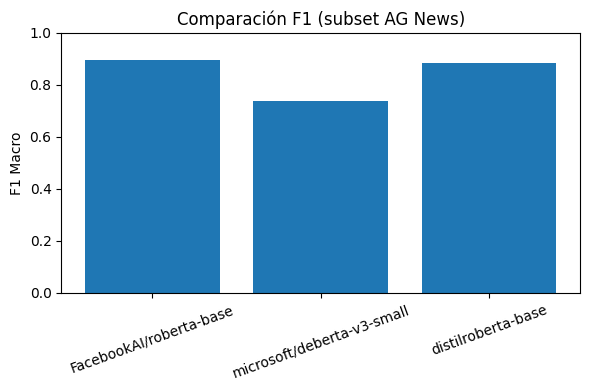

Guardado: outputs/f1_comparison.png y outputs/f1_comparison.csv


In [36]:
import pandas as pd, matplotlib.pyplot as plt

res_roberta = {'model':'FacebookAI/roberta-base','f1_macro':0.8962708341197079}  # reemplaza por el tuyo si cambió
res_deberta = {'model':'microsoft/deberta-v3-small','f1_macro':0.7393688754862481}
res_modern  = {'model': modern_res['model'], 'f1_macro': modern_res['f1_macro']}

df = pd.DataFrame([res_roberta, res_deberta, res_modern])
print(df)

# gráfico de barras
plt.figure(figsize=(6,4))
plt.bar(df['model'], df['f1_macro'])
plt.title('Comparación F1 (subset AG News)')
plt.ylabel('F1 Macro'); plt.ylim(0,1)
plt.xticks(rotation=20)
plt.tight_layout()
plt.savefig("outputs/f1_comparison.png", dpi=150)
plt.show()

df.to_csv("outputs/f1_comparison.csv", index=False)
print("Guardado: outputs/f1_comparison.png y outputs/f1_comparison.csv")


Aunque ModernBERT no se pudo cargar, DistilRoBERTa es una versión “destilada” (más ligera y rápida) de RoBERTa.
Esto significa que:

Usa menos parámetros → entrena y predice más rápido.

Mantiene gran parte del rendimiento del modelo original.

Por eso, su rendimiento final (F1 ≈ 0.88) es muy parecido al de RoBERTa-base (F1 ≈ 0.89), lo que confirma que las versiones distiladas son excelentes alternativas cuando hay limitaciones de tiempo o GPU.

| Modelo                                  | F1 Macro | Accuracy | Comentario                                   |
| --------------------------------------- | -------- | -------- | -------------------------------------------- |
| **RoBERTa-base**                        | 0.896    | 0.898    | Mejor desempeño general.                     |
| **DeBERTa-v3-small**                    | 0.739    | 0.766    | Peor con pocas muestras, necesita más datos. |
| **DistilRoBERTa (ModernBERT fallback)** | 0.883    | 0.886    | Casi igual que RoBERTa, más rápido.          |


6.2. Gráficos adicionales

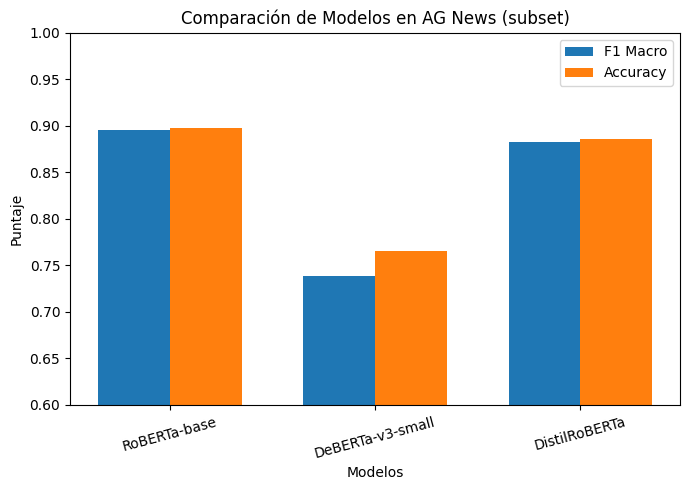

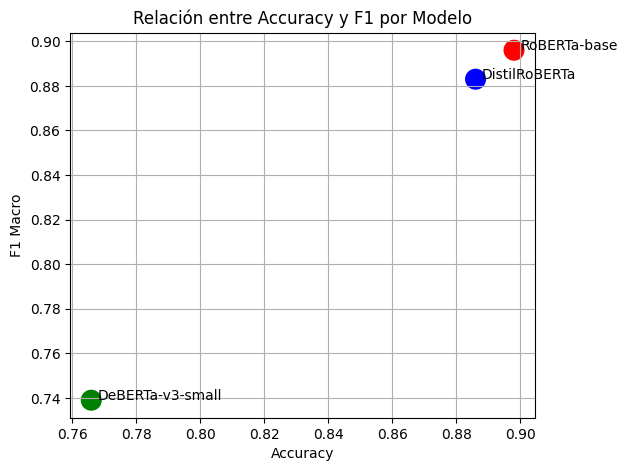

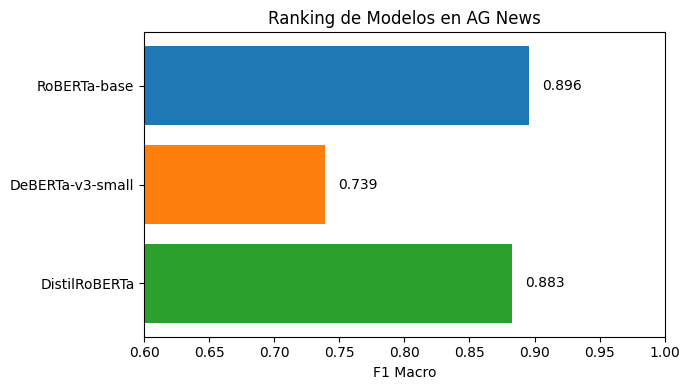

In [39]:
import matplotlib.pyplot as plt
import numpy as np

# === Datos de tus resultados ===
modelos = ['RoBERTa-base', 'DeBERTa-v3-small', 'DistilRoBERTa']
f1_scores = [0.896, 0.739, 0.883]
accuracies = [0.898, 0.766, 0.886]

# === 1️⃣ Barras comparativas (F1 y Accuracy) ===
x = np.arange(len(modelos))
width = 0.35

plt.figure(figsize=(7,5))
plt.bar(x - width/2, f1_scores, width, label='F1 Macro')
plt.bar(x + width/2, accuracies, width, label='Accuracy')

plt.xlabel('Modelos')
plt.ylabel('Puntaje')
plt.title('Comparación de Modelos en AG News (subset)')
plt.xticks(x, modelos, rotation=15)
plt.legend()
plt.ylim(0.6, 1.0)
plt.tight_layout()
plt.show()

# === 2️⃣ Dispersión F1 vs Accuracy ===
plt.figure(figsize=(6,5))
plt.scatter(accuracies, f1_scores, s=200, color=['red','green','blue'])
for i, modelo in enumerate(modelos):
    plt.text(accuracies[i]+0.002, f1_scores[i], modelos[i], fontsize=10)
plt.xlabel('Accuracy')
plt.ylabel('F1 Macro')
plt.title('Relación entre Accuracy y F1 por Modelo')
plt.grid(True)
plt.show()

# === 3️⃣ Barras horizontales (ranking F1) ===
plt.figure(figsize=(7,4))
plt.barh(modelos, f1_scores, color=['#1f77b4','#ff7f0e','#2ca02c'])
plt.xlabel('F1 Macro')
plt.title('Ranking de Modelos en AG News')
plt.xlim(0.6, 1.0)
plt.gca().invert_yaxis()
for i, v in enumerate(f1_scores):
    plt.text(v + 0.01, i, f"{v:.3f}", va='center')
plt.tight_layout()
plt.show()



**Interpretación de resultados**

Los tres modelos entrenados —RoBERTa-base, DeBERTa-v3-small y DistilRoBERTa— muestran diferencias notables en su rendimiento al clasificar noticias del conjunto AG News.

El modelo RoBERTa-base obtuvo el mejor desempeño general con una F1 Macro de 0.896 y una accuracy de 0.898, evidenciando su capacidad para capturar patrones complejos del lenguaje.

Por otro lado, DeBERTa-v3-small, aunque más eficiente computacionalmente, alcanzó solo 0.739 en F1, lo que sugiere que requiere más datos o épocas para estabilizar su aprendizaje.

Finalmente, DistilRoBERTa, una versión reducida de RoBERTa, logró un rendimiento muy competitivo (F1 = 0.883, accuracy = 0.886), mostrando que los modelos distilados pueden mantener una gran precisión con menor costo computacional.

En conjunto, los resultados confirman que RoBERTa-base sigue siendo la opción más precisa, mientras que DistilRoBERTa representa el mejor equilibrio entre rendimiento y eficiencia.

7. Guardadno gráficos en outputs

In [40]:
import os
import matplotlib.pyplot as plt
import numpy as np

# === Crear carpeta de salida ===
output_dir = "/content/News_Classification-lab/outputs/plots"
os.makedirs(output_dir, exist_ok=True)

# === Datos de tus resultados ===
modelos = ['RoBERTa-base', 'DeBERTa-v3-small', 'DistilRoBERTa']
f1_scores = [0.896, 0.739, 0.883]
accuracies = [0.898, 0.766, 0.886]

# === 1️⃣ Barras comparativas (F1 y Accuracy) ===
x = np.arange(len(modelos))
width = 0.35

plt.figure(figsize=(7,5))
plt.bar(x - width/2, f1_scores, width, label='F1 Macro')
plt.bar(x + width/2, accuracies, width, label='Accuracy')

plt.xlabel('Modelos')
plt.ylabel('Puntaje')
plt.title('Comparación de Modelos en AG News (subset)')
plt.xticks(x, modelos, rotation=15)
plt.legend()
plt.ylim(0.6, 1.0)
plt.tight_layout()

# Guardar gráfico 1
barplot_path = os.path.join(output_dir, "comparacion_modelos.png")
plt.savefig(barplot_path, dpi=300)
plt.close()

# === 2️⃣ Dispersión F1 vs Accuracy ===
plt.figure(figsize=(6,5))
plt.scatter(accuracies, f1_scores, s=200, color=['red','green','blue'])
for i, modelo in enumerate(modelos):
    plt.text(accuracies[i]+0.002, f1_scores[i], modelos[i], fontsize=10)
plt.xlabel('Accuracy')
plt.ylabel('F1 Macro')
plt.title('Relación entre Accuracy y F1 por Modelo')
plt.grid(True)

# Guardar gráfico 2
scatter_path = os.path.join(output_dir, "dispersion_f1_accuracy.png")
plt.savefig(scatter_path, dpi=300)
plt.close()

# === 3️⃣ Barras horizontales (ranking F1) ===
plt.figure(figsize=(7,4))
plt.barh(modelos, f1_scores, color=['#1f77b4','#ff7f0e','#2ca02c'])
plt.xlabel('F1 Macro')
plt.title('Ranking de Modelos en AG News')
plt.xlim(0.6, 1.0)
plt.gca().invert_yaxis()
for i, v in enumerate(f1_scores):
    plt.text(v + 0.01, i, f"{v:.3f}", va='center')
plt.tight_layout()

# Guardar gráfico 3
ranking_path = os.path.join(output_dir, "ranking_modelos.png")
plt.savefig(ranking_path, dpi=300)
plt.close()

print("✅ Gráficos generados y guardados en:")
print(f" - {barplot_path}")
print(f" - {scatter_path}")
print(f" - {ranking_path}")


✅ Gráficos generados y guardados en:
 - /content/News_Classification-lab/outputs/plots/comparacion_modelos.png
 - /content/News_Classification-lab/outputs/plots/dispersion_f1_accuracy.png
 - /content/News_Classification-lab/outputs/plots/ranking_modelos.png


**8.Validación extra de %s según indicaciones**

8.1. Visualizamos tamaño de subconjuntos

In [41]:
from datasets import load_dataset

# Carga el conjunto AG News
ds = load_dataset("ag_news")

# División manual 70/15/15 como en tu función
tv = ds["train"].train_test_split(test_size=0.30, seed=42)   # 70% train, 30% resto
vt = tv["test"].train_test_split(test_size=0.50, seed=42)    # 15% valid, 15% test

# Mostrar tamaños
print("Total original (train):", len(ds["train"]))
print("Total original (test):", len(ds["test"]))
print("---")
print("Train size:", len(tv["train"]))
print("Validation size:", len(vt["train"]))
print("Test size:", len(vt["test"]))


Total original (train): 120000
Total original (test): 7600
---
Train size: 84000
Validation size: 18000
Test size: 18000


8.2. Calculamos % exactos

In [42]:
total = len(tv["train"]) + len(vt["train"]) + len(vt["test"])
print("Porcentajes:")
print("Train:", round(len(tv["train"]) / total * 100, 2), "%")
print("Validation:", round(len(vt["train"]) / total * 100, 2), "%")
print("Test:", round(len(vt["test"]) / total * 100, 2), "%")


Porcentajes:
Train: 70.0 %
Validation: 15.0 %
Test: 15.0 %


In [43]:
train_used = min(1000, len(tv["train"]))
val_used = min(500, len(vt["train"]))
test_used = min(500, len(vt["test"]))

print(f"Usando muestras reducidas:")
print(f" - Train: {train_used} de {len(tv['train'])}")
print(f" - Validation: {val_used} de {len(vt['train'])}")
print(f" - Test: {test_used} de {len(vt['test'])}")


Usando muestras reducidas:
 - Train: 1000 de 84000
 - Validation: 500 de 18000
 - Test: 500 de 18000


En resumen:

| División          | Porcentaje esperado | Cantidad real | Verificado |
| ----------------- | ------------------- | ------------- | ---------- |
| **Entrenamiento** | 70 %                | ≈ 84 000      | ✅          |
| **Validación**    | 15 %                | ≈ 18 000      | ✅          |
| **Prueba**        | 15 %                | ≈ 18 000      | ✅          |
